In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn, optim # optim here allow us to get optimizers
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F # let us to use ReLU and log softmax
# import helper
from sklearn.metrics import confusion_matrix

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
device=torch.device("cuda:0")

In [3]:
transform = transforms.Compose([transforms.ToTensor(),   # ToTensor()能够把灰度范围从0-255变换到0-1之间
                                transforms.Normalize((0.5,), (0.5,))])  

In [4]:
# Download and load the training data
trainset = torchvision.datasets.FashionMNIST('./data/MNIST_data/', download=True, train=True, transform=transform)

# Download and load the test data
testset = torchvision.datasets.FashionMNIST('./data/MNIST_data/', download=True, train=False, transform=transform)

In [5]:
# 创建训练集和测试集数据加载器
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True)

## 残差快

残差块里首先有2个有相同输出通道数的3×3卷积层。 每个卷积层后接一个批量规范化层和ReLU激活函数。 然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前。 这样的设计要求2个卷积层的输出与输入形状一样，从而使它们可以相加。 如果想改变通道数，就需要引入一个额外的1×1卷积层来将输入变换成需要的形状后再做相加运算。 残差块的实现如下：

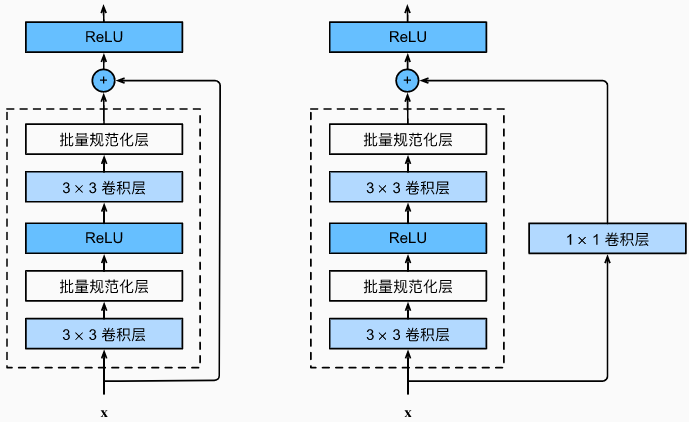

In [6]:
class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

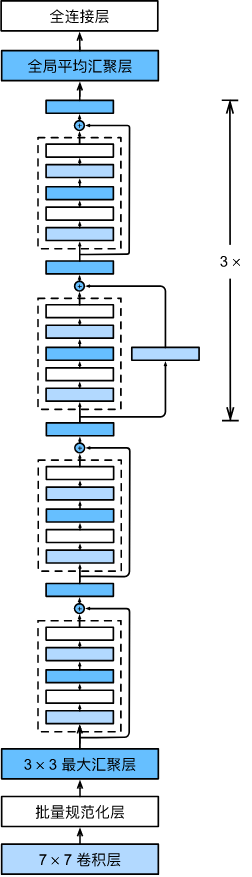

In [7]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._resnet_block(64, 64, 2, first_block=True)
        self.layer2 = self._resnet_block(64, 128, 2)
        self.layer3 = self._resnet_block(128, 256, 2)
        self.layer4 = self._resnet_block(256, 512, 2)
        self.linear = nn.Linear(512, num_classes)
        self.Flatten = nn.Flatten()

    def _resnet_block(self, input_channels, num_channels, num_residuals,
                 first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(input_channels, num_channels,
                                    use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(num_channels, num_channels))
        return nn.Sequential(*blk)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.avg_pool2d(out, 3, 2)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 1)
        out = self.Flatten(out)
        out = self.linear(out)
        return out

In [8]:
model=ResNet()
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (lay

In [9]:
# 创建网络，定义误差、学习率和优化器
# model = ResNet()
model = model.to(device)
# 负对数似然损失函数，用于处理多分类问题，输入是对数化的概率值。
# 对于包含N个样本的batch数据 D(x, y)，x 是神经网络的输出，并进行归一化和对数化处理。y是样本对应的类别标签，每个样本可能是C种类别中的一个
error = nn.CrossEntropyLoss()
error = error.to(device) 
learning_rate=0.001 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# 训练网络
num_epochs = 100
for e in range(num_epochs):
    running_loss = 0
    for images, labels in trainloader:
        images=images.to(device)
        labels=labels.to(device)
        pre = model(images)
        loss = error(pre, labels)
        optimizer.zero_grad() 
        loss.backward() # 反向传播
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}", end=" ")
        
    model.eval()
    with torch.no_grad():
        total=0
        correct=0
        for images,labels in testloader:
            images=images.to(device)
            labels=labels.to(device)
            pre_val=model(images)
            mx_index=torch.argmax(pre_val,dim=1)
            total+=labels.numel()
            correct+=sum(mx_index==labels).item()
        print(f"Test Accuracy {correct/total*100:.2f}")

Training loss: 1.2797691862633889 Test Accuracy 74.89
Training loss: 0.5146817270745623 Test Accuracy 81.67
Training loss: 0.4119672326331443 Test Accuracy 85.42
Training loss: 0.3588889146738864 Test Accuracy 86.29
Training loss: 0.3299960606275721 Test Accuracy 87.65
Training loss: 0.3059055967533842 Test Accuracy 88.25
Training loss: 0.2843025969063982 Test Accuracy 88.71
Training loss: 0.27157654768608985 Test Accuracy 88.46
Training loss: 0.25687026730243195 Test Accuracy 89.12
Training loss: 0.2515259522706904 Test Accuracy 88.82
Training loss: 0.24005742206218394 Test Accuracy 89.26
Training loss: 0.2326681651967637 Test Accuracy 89.63
Training loss: 0.21741386962697862 Test Accuracy 89.73
Training loss: 0.21245636026910011 Test Accuracy 89.30
Training loss: 0.2054459755725049 Test Accuracy 90.19
Training loss: 0.1932774266029926 Test Accuracy 89.87
Training loss: 0.19067597538232803 Test Accuracy 90.12
Training loss: 0.18129470164471484 Test Accuracy 90.41
Training loss: 0.1814